### Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns

---
### Upload Dataset

In [2]:
X_und = pd.read_csv("cleaned_rain_x.csv")
y_und = pd.read_csv("cleaned_rain_y.csv")

---
### Split into testing and training data

In [3]:
x_train, x_test, y_train, y_test = train_test_split(X_und, y_und, test_size=0.25, random_state=42)

In [4]:
x_train.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
x_test.drop(columns=['Unnamed: 0'], axis=1, inplace=True)

/Users/abbycarr/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [5]:
x_train.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
22845,-0.925855,-1.343428,0.213256,0.145445,1.220578,0.274457,0.183993,0.755625,1.500069,0.894962,...,1.101758,1.088941,-0.929551,-0.843587,-0.839679,1.169532,-0.846416,-0.822150,1.097495,1.094764
42446,1.314874,0.856220,0.352357,0.376646,0.437868,0.382385,1.842494,-0.917119,-0.666636,0.499156,...,-0.907640,1.088941,1.075788,1.185414,-0.839679,-0.855043,-0.846416,-0.822150,-0.911166,1.094764
5989,0.610645,0.741206,-0.273598,0.376646,0.214237,0.166529,0.137924,-0.533211,-0.666636,0.894962,...,-0.907640,-0.918324,-0.929551,-0.843587,1.190932,1.169532,-0.846416,1.216322,1.097495,-0.913439
39347,-0.077579,0.223641,0.491458,-1.126157,-1.462998,0.382385,-0.645257,-0.231568,-0.666636,0.499156,...,-0.907640,-0.918324,-0.929551,-0.843587,1.190932,1.169532,-0.846416,1.216322,1.097495,-0.913439
31998,-1.117918,-0.811487,-0.690902,-0.779357,0.214237,1.299772,-0.092423,1.797663,1.500069,-1.479872,...,-0.907640,-0.918324,1.075788,-0.843587,-0.839679,1.169532,-0.846416,1.216322,1.097495,-0.913439


---
# Evaluators
---

In [6]:
def conf(TP, FP, TN, FN):
    cf = np.array([[TN, FP], [FN, TP]])
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cf.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cf.flatten()/np.sum(cf)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf, annot=labels, fmt='', 
                cmap=sns.diverging_palette(230, 20, center='light'))

In [7]:
def TF(y_actu, y_pred):
    TP = np.sum(np.logical_and(y_pred == 1, y_actu == 1))
    TN = np.sum(np.logical_and(y_pred == 0, y_actu == 0))
    FP = np.sum(np.logical_and(y_pred == 1, y_actu == 0))
    FN = np.sum(np.logical_and(y_pred == 0, y_actu == 1))
    conf(TP, FP, TN, FN)
    return TP, FP, TN, FN

In [8]:
def eval(models, test_x, test_y):
    for m in models:
        model = m[0]
        TP, FP, TN, FN = TF(test_y, np.array(model.predict(test_x)))
        acc = (TP + TN) / (TP + TN + FP + FN)
        pre = TP / (TP + FP)
        re = TP / (FN + TP)
        f1 = (2 * (pre * re)) / (pre + re)
        scoring = {m[1]:{"Accuracy":acc, "Precision":pre,"Recall":re,"F1":f1}}
    return pd.DataFrame(scoring)

---
# SVM Implementation
---

In [9]:
class SVM():

    def __init__(self, lr=0.001, iterations=1000, lambda_ = 0.01):

        self.lr = lr
        self.iters = iterations
        self.lambda_ = lambda_
        self.fit()

    def fit(self, x=x_train, y=y_train["RainTomorrow"]):
        
        self.x = np.array(x)
        self.y = y
        
        self.m, self.n = x.shape
        self.w = np.zeros(self.n)
        
        # bias
        self.b = 1

        # Update coeffs w/ Gradient Descent
        for i in range(self.iters):
            self.update_vals()

    def update_vals(self):
        
        target = np.where(self.y <= 0, -1, 1)

        for index, i in enumerate(self.x):

            condition = target[index] * (np.dot(i, self.w) - self.b) >= 1

            if (condition == True):

                dw = 2 * self.lambda_ * self.w
                db = 0
            
            else:

                g = np.dot(i, target[index])
                dw = 2 * self.lambda_ * self.w - g
                db = target[index]

            self.w = self.w - self.lr * dw
            self.b = self.b - self.lr * db

    def predict(self, x_test):

        output = np.dot(x_test, self.w) - self.b
        predicted = np.sign(output)
        y_pred = np.where(predicted <= -1, 0, 1)

        return y_pred

---
# RESULTS
---

,SVM
Accuracy,0.773387
F1,0.768948
Precision,0.790824
Recall,0.748250


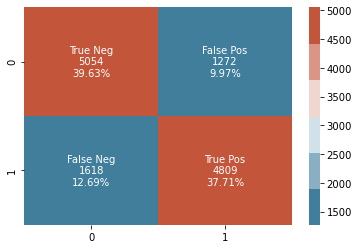

In [10]:
SVM = SVM()
eval([[SVM, "SVM"]], x_test, y_test['RainTomorrow'])